In [17]:
import sys; sys.path.append('..'); from wwa import *

Xn, Xx, Yn, Yx = [-67,-47,-27,-7]
xn, xx, yn, yx = [-60,-54,-23,-15]
mapproj = cartopy.crs.PlateCarree()

In [9]:
sf = gpd.read_file("sf/pantanal")

In [10]:
days = pd.date_range(start = "2020-01-01", end = "2021-01-01")
labelticks = [i+1 for i in range(366) if (days[i].day) == 15]
labels = [days[i].strftime("%b")[0] for i in range(366) if (days[i].day) == 15]

---
# Fire activity

## Cumulative fire activity

In [33]:
px_daily = pd.read_csv("data/modis-active-pixels_pantanal.csv", index_col = "acq_date", parse_dates = ["acq_date"])

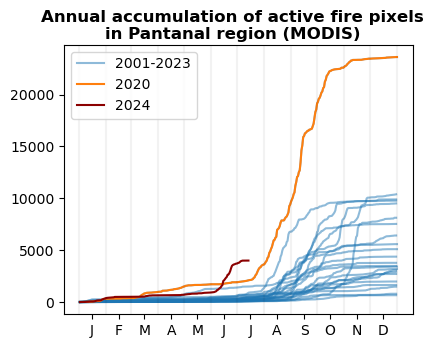

In [34]:
fig, ax = plt.subplots(figsize = (4.5,3.5), dpi = 100)

y = 2001
ts_y = px_daily.loc[str(y)]
ax.plot(ts_y.index.dayofyear, ts_y.cumsum(), color = "tab:blue", alpha = 0.5, label = "2001-2023")

for y in range(2002,2024):
    ts_y = px_daily.loc[str(y)]
    ax.plot(ts_y.index.dayofyear, ts_y.cumsum(), color = "tab:blue", alpha = 0.5, label = "_years")
    
y = 2020
ts_y = px_daily.loc[str(y)]
ax.plot(ts_y.index.dayofyear, ts_y.cumsum(), color = "tab:orange", label = "2020")

y = 2024
ts_y = px_daily.loc[str(y)]
ax.plot(ts_y.index.dayofyear, ts_y.cumsum(), color = "darkred", label = "2024")

ax.set_xticks(labelticks)
ax.set_xticklabels(labels)

[ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]

plt.suptitle("Annual accumulation of active fire pixels\nin Pantanal region (MODIS)", fontweight = "bold")

ax.legend()

plt.savefig("fig/cum_modis-pixels.png")

## Correlation between DSR & fire activity

In [6]:
dsr_era5 = xr.open_dataset("data/fwi_daily_pantanal_era5.nc").dsr.resample(time = "MS").sum().sel(time = slice(None, "2024-06"))

px_monthly = pd.read_csv("data/modis-active-pixels_pantanal.csv", index_col = "acq_date", parse_dates = ["acq_date"]).resample("MS").sum().loc[slice(None, "2024-06")]

In [7]:
df = merge_byindex([dsr_era5.to_dataframe(), px_monthly]).dropna(axis = 0, how = "any")
df["log_px"] = np.log(df.px)

/rds/general/user/cb2714/home/anaconda3/envs/wwa/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


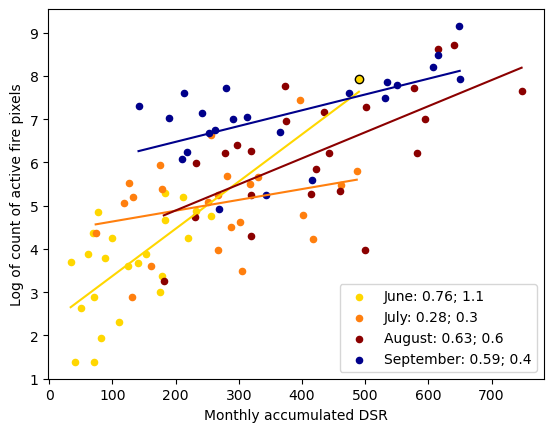

In [31]:
fig, ax = plt.subplots()

mcolours = {"6" : "gold", "7" : "tab:orange", "8" : "darkred", "9" : "darkblue", "10" : "tab:purple"}
mnames = {"6" : "June", "7" : "July", "8" : "August", "9" : "September", "10" : "October"}

for m in list(mcolours.keys())[:-1]:
    
    df_m = df.loc[(df.index.month == int(m))]#.loc[slice(None,"2023")]
    
    # coeffs of best fit & correlation coefficient
    a,b = np.polyfit(df_m.dsr, df_m.log_px,1)
    r = str(round(df_m.corr()["dsr"]["log_px"],2))
    
    df_m.plot(ax = ax, color = mcolours[m], kind = "scatter", x = "dsr", y = "log_px", label = mnames[m]+": "+r+"; "+str(round(a*100,1)),
              xlabel = "Monthly accumulated DSR", ylabel = "Log of count of active fire pixels")
    
    xyline(df_m.dsr, df_m.log_px, color = mcolours[m], ax = ax)
    
#     df_x = df.loc[(df.index.month == int(m)) & (df.index.year < 2024)]
#     xyline(df_x.dsr, df_x.log_px, color = mcolours[m], ax = ax)
    
ax.scatter(df.loc["2024-06", "dsr"], df.loc["2024-06", "log_px"], color = mcolours["6"], marker = "o", ec = "k")

# June correlation excluding 2024 is 0.57; including 2024 is 0.76
plt.savefig("fig/dsr-activefire-correlation.png")

# DSR & sub-indices

In [5]:
ds = xr.open_dataset("data/fwi_daily_pantanal_era5.nc")
varbls = ["dsr", "bui", "isi", "dc", "dmc", "ffmc"]

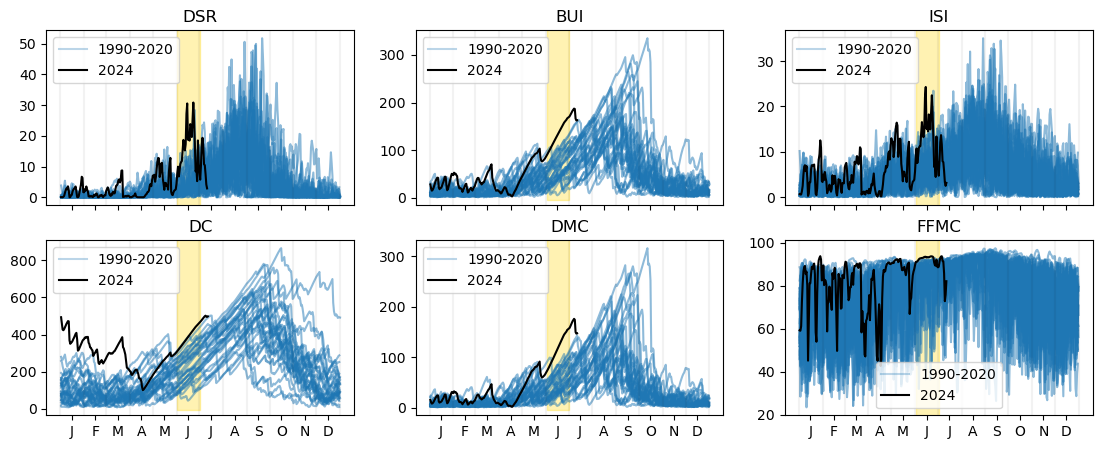

In [6]:
nc = 3; nr = 2

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (4.5*nc, 2.5*nr), dpi = 100, sharex = True)

for i in range(len(varbls)):
    
    ax = fig.axes[i]
    vnm = varbls[i]
    
    ts = ds[vnm]
    
    y = "2000"; ts_y = ts.loc[y]; ax.plot(ts_y.time.dt.dayofyear, ts_y, "tab:blue", alpha = 0.3, label = "1990-2020")
    for y in range(1990,2021):
        ts_y = ts.sel(time = str(y))
        ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.5, label = "_years")
        
#     y = "2020"; ts_y = ts.loc[y]; ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", label = y, lw = 1)
    y = "2024"; ts_y = ts.sel(time = str(y)); ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = y)
    ax.set_title(vnm.upper())
    
    ax.legend()
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    
    ax.add_patch(Rectangle((ts.sel(time = "2024-06-01").time.dt.dayofyear.values,-5), 30, 1000, color = "gold", alpha = 0.3))
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]
    
plt.savefig("fig/subindices_2024.png")

## Sub-subindices

In [45]:
ds = xr.open_dataset("data/vars_daily_pantanal_era5.nc")

# varbls = list(ds.data_vars); nc = 3; nr = 2
varbls = ["pr", "tmax", "rh_mean", "sfcWind"]; nc = 4; nr = 1


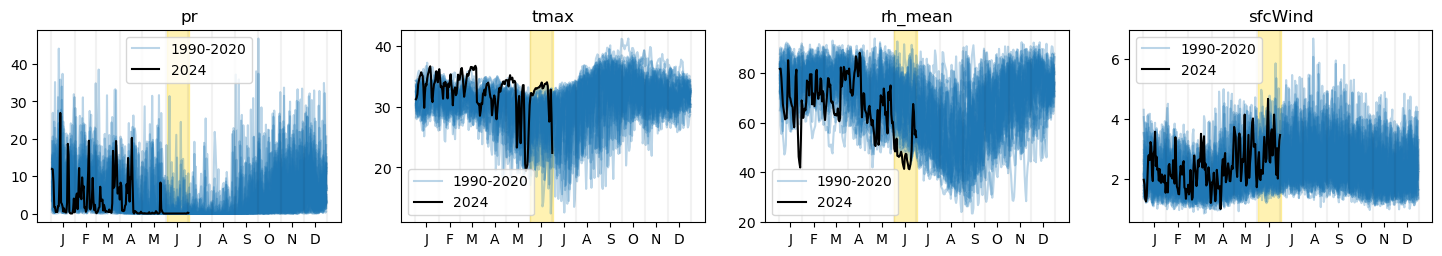

In [46]:
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (4.5*nc, 2.5*nr), dpi = 100, sharex = True)

for i in range(len(varbls)):
    
    ax = fig.axes[i]
    vnm = varbls[i]
    
    ts = ds[vnm]
    
    y = "1990"; ts_y = ts.loc[y]; ax.plot(ts_y.time.dt.dayofyear, ts_y, "tab:blue", alpha = 0.3, label = "1990-2020")
    for y in range(1991,2021):
        ts_y = ts.sel(time = str(y))
        ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "tab:blue", alpha = 0.3, label = "_years")
        
#     y = "2020"; ts_y = ts.loc[y]; ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "darkred", label = y, lw = 1)
    y = "2024"; ts_y = ts.sel(time = str(y)); ax.plot(ts_y.time.dt.dayofyear, ts_y, color = "k", label = y)
    ax.set_title(vnm)
    
    ax.legend()
    ax.set_xticks(labelticks)
    ax.set_xticklabels(labels)
    
    ax.add_patch(Rectangle((ts.sel(time = "2024-06-01").time.dt.dayofyear.values,-5), 30, 1000, color = "gold", alpha = 0.3)) # 20-day period starting from July 1st
    [ax.axvline(x, color = "k", alpha = 0.05) for x in range(367) if (days[x].day) == 1]
    
plt.savefig("fig/subsubindices_2024.png")

### Trends in variables over time

In [92]:
nm = 1

months = ["June", "May-June"][nm-1]

ds = xr.open_dataset("data/vars_daily_pantanal_era5.nc").resample(time = "MS").mean().rolling(time = nm).mean().groupby("time.month")[6]
ds["tmax"] = ds.tmax.assign_attrs(long_name = "Daily maximum temperature", units = "degC")
ds["sfcWind"] = ds.sfcWind.assign_attrs(long_name = "Wind speed")

# varbls = list(ds.data_vars); nc = 3; nr = 2
varbls = ["pr", "tmax", "rh_mean", "sfcWind"]; nc = 4; nr = 1

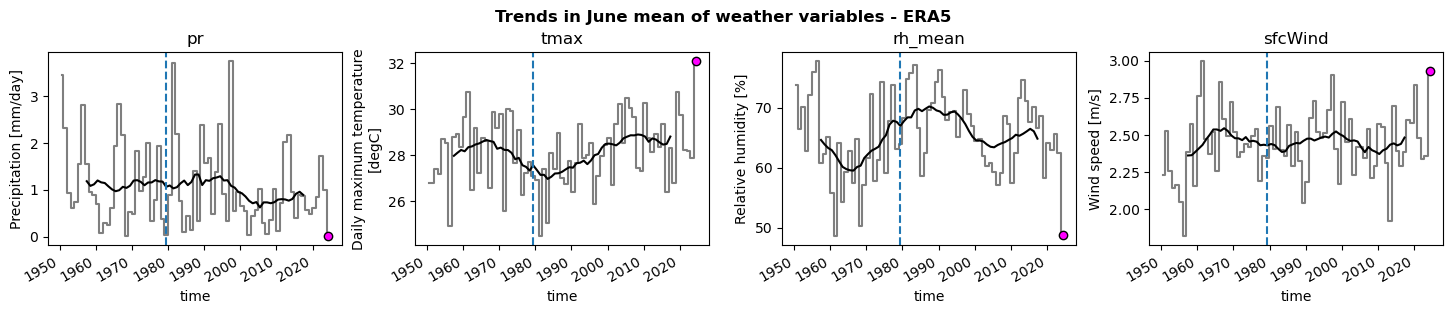

In [93]:
fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (4.5*nc, 2.5*nr), dpi = 100, sharex = True)
plt.subplots_adjust(wspace = 0.25)

for i in range(len(varbls)):
    
    ax = fig.axes[i]
    vnm = varbls[i]
    
    ts = ds[vnm]
    ts.plot(ax = ax, drawstyle = "steps-mid", color = "k", alpha = 0.5)
    ax.scatter(ts.sel(time = "2024").time, ts.sel(time = "2024"), marker = "o", color = "magenta", edgecolor = "k", zorder = 99)
    ts.rolling(time = 15, center = True).mean().plot(ax = ax, color = "k")
    ax.axvline(ts.sel(time = "1979").time, color = "tab:blue", ls = "--")
    ax.set_title(vnm)
    
plt.suptitle("Trends in "+months+" mean of weather variables - ERA5", y = 1.05, fontweight = "bold")
        
plt.savefig("fig/subsubindices_trends-"+months.lower()+".png")

# Relationship between monthly temperature & precip

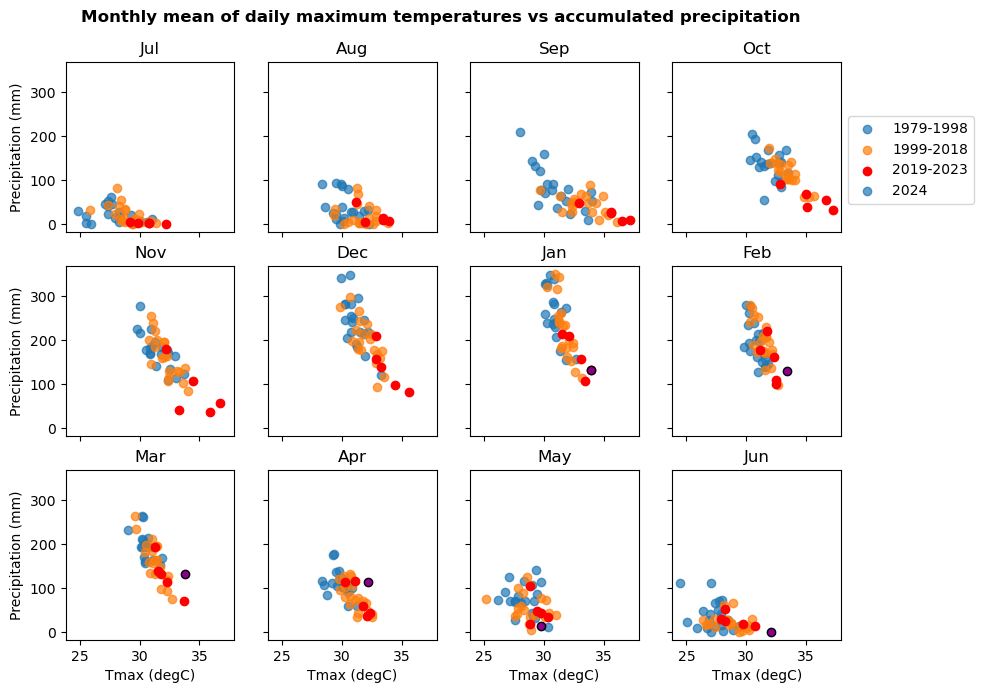

In [15]:
ds = xr.open_dataset("data/vars_daily_pantanal_era5.nc").resample(time = "MS").mean()

ds_c20 = ds.sel(time = slice("1979","1998"))
ds_c21 = ds.sel(time = slice("1999","2018"))
ds_recent = ds.sel(time = slice("2019", "2023"))

fig, axs = plt.subplots(ncols = 4, nrows = 3, figsize = (4*2.5, 3*2.5), sharex = True, sharey = True)

for i in range(12):
    ax = fig.axes[i]
    m = ((i+6) % 12)+1
    
    ndays = ds.sel(time = "2023").groupby("time.month")[m].time.dt.daysinmonth.values
    
    ax.scatter(ds_c20.groupby("time.month")[m].tmax, ds_c20.groupby("time.month")[m].pr * ndays, alpha = 0.7)
    ax.scatter(ds_c21.groupby("time.month")[m].tmax, ds_c21.groupby("time.month")[m].pr * ndays, alpha = 0.7)
    ax.scatter(ds_recent.groupby("time.month")[m].tmax, ds_recent.groupby("time.month")[m].pr * ndays, color = "red")
    if m <= 6: 
        ax.scatter(ds.sel(time = "2024").groupby("time.month")[m].tmax, ds.sel(time = "2024").groupby("time.month")[m].pr * ndays, color = "darkmagenta", edgecolor = "k")
    
    ax.set_title(ds_c20.isel(time = m-1).time.dt.strftime("%b").values)
    
for ax in axs[:,0]: ax.set_ylabel("Precipitation (mm)")
for ax in axs[-1,:]: ax.set_xlabel("Tmax (degC)")
fig.legend([str(da.time.dt.year.min().values)+"-"+str(da.time.dt.year.max().values) for da in [ds_c20, ds_c21, ds_recent]] + ["2024"], bbox_to_anchor = (0.9,0.75), loc = "center left")

plt.suptitle("Monthly mean of daily maximum temperatures vs accumulated precipitation", fontweight= "bold", y = 0.95)
plt.savefig("fig/monthly-pr-temp-distribution.png")

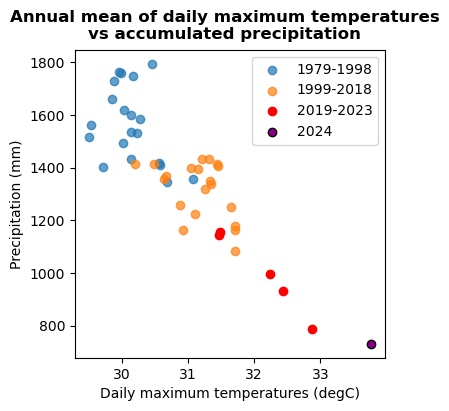

In [16]:
ds = xr.open_dataset("data/vars_daily_pantanal_era5.nc").resample(time = "AS-JUL", label = "right").mean()

ds_c20 = ds.sel(time = slice("1979","1998"))
ds_c21 = ds.sel(time = slice("1999","2018"))
ds_recent = ds.sel(time = slice("2019", "2023"))

fig, ax = plt.subplots(figsize = (4,4), sharex = True, sharey = True)

ax.scatter(ds_c20.tmax, ds_c20.pr*365, label = str(ds_c20.time.dt.year.min().values)+"-"+str(ds_c20.time.dt.year.max().values), alpha = 0.7)
ax.scatter(ds_c21.tmax, ds_c21.pr*365, label = str(ds_c21.time.dt.year.min().values)+"-"+str(ds_c21.time.dt.year.max().values), alpha = 0.7)
ax.scatter(ds_recent.tmax, ds_recent.pr*365, label = str(ds_recent.time.dt.year.min().values)+"-"+str(ds_recent.time.dt.year.max().values), color = "red")
ax.scatter(ds.sel(time = "2024").tmax, ds.sel(time = "2024").pr*365, label = "2024", color = "darkmagenta", edgecolor = "k")

ax.set_ylabel("Precipitation (mm)")
ax.set_xlabel("Daily maximum temperatures (degC)")
ax.legend()

plt.suptitle("Annual mean of daily maximum temperatures\nvs accumulated precipitation", fontweight = "bold")
plt.savefig("fig/annual-pr-temp-distribution.png")

# Map of DSR anomaly

In [78]:
dsr = xr.open_dataset("data/era5_dsr_-60_-54_-23_-15.nc").dsr.resample(time = "MS").sum().groupby("time.month")[6]
dsr_clim = dsr.sel(time = slice("1990", "2020")).mean("time")
dsr_2024 = dsr.sel(time = "2024-06-01")
dsr_anom = dsr_2024 - dsr_clim
dsr_relanom = (dsr_anom / dsr_clim) * 100

<GeoAxesSubplot: title={'center': 'June 2024 monthly severity anomaly\nwrt 1990-2020 climatology'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

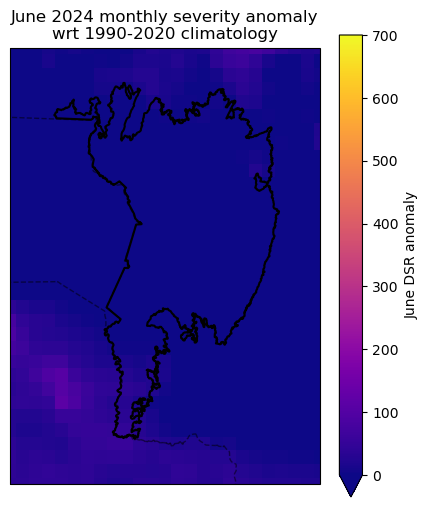

In [77]:
fig, ax = plt.subplots(ncols = 1, figsize = (5,6), subplot_kw = {"projection" : mapproj, "extent" : (xn,xx,yn,yx)})

dsr_anom.plot(ax = ax, vmin = 0, vmax = 700, cmap = "plasma", cbar_kwargs ={"label": "June DSR anomaly"})
ax.set_title("June 2024 monthly severity anomaly\nwrt 1990-2020 climatology")

ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
sf.boundary.plot(ax = ax, color = "k")

<GeoAxesSubplot: title={'center': 'June 2024 relative monthly severity anomaly\nwrt 1990-2020 climatology'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

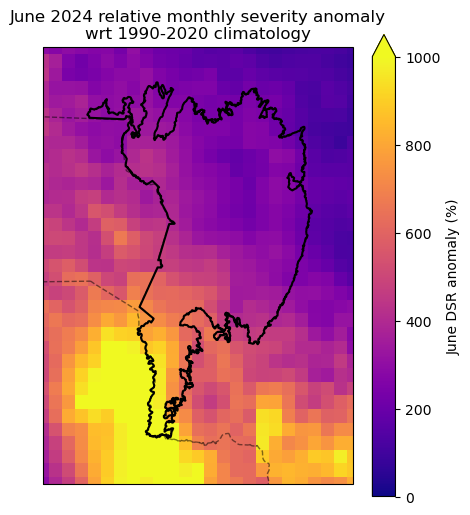

In [75]:
fig, ax = plt.subplots(ncols = 1, figsize = (5,6), subplot_kw = {"projection" : mapproj, "extent" : (xn,xx,yn,yx)})

dsr_relanom.plot(ax = ax, cmap = "plasma", vmin = 0, vmax = 1000, cbar_kwargs = {"label": "June DSR anomaly (%)"})
ax.set_title("June 2024 relative monthly severity anomaly\nwrt 1990-2020 climatology")

ax.add_feature(cartopy.feature.BORDERS, color = "k", ls = "--", alpha = 0.5)
sf.boundary.plot(ax = ax, color = "k")